In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

def h1n1_data_reader(filename='process_data.csv'):
    data = pd.read_csv(filename)
    X = data.drop(['h1n1_vaccine','respondent_id','seasonal_vaccine'],axis = 1)
    y =  data['h1n1_vaccine']
    return X, y

In [2]:
# from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score,f1_score
# from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')
def classification_kpi(G,S):
    """_summary_

    Args:
        G (nx.Graph): _description_
        S (list): list of nodes (list of columns)
    """
    cols = list(S)
    if len(cols) == 0:
        return 0
    else:
        X_train, X_test, y_train, y_test = train_test_split(X[cols], y, test_size=0.2, random_state=10)
        lgb_model = lgb.LGBMClassifier(learning_rate=0.02,
               min_child_samples=4, n_estimators=45, num_leaves=144,
               reg_alpha=0.1, reg_lambda=0.003,
               verbose=-1)
        lgb_model.fit(X_train,y_train)
        lgb_pred = lgb_model.predict(X_test)
        auc = accuracy_score(y_test, lgb_pred)
        f1 = f1_score(y_test, lgb_pred)
        return f1
#         auc = roc_auc_score(y_test, lg

In [3]:
# import shapG and necessary libraries
import networkx as nx
import shapG.shapley as shapley
import shapG.plot as shapGplot
import seaborn
from shapG.utils import corr_generator, create_minimal_edge_graph, matrix_generator, kl, kl_mi_matrix
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr,kendalltau,spearmanr
from scipy.spatial.distance import cosine


In [4]:
def get_rank(method, X, y):
    # small p-value (<0.05) no there is a correlation between the two variables
    # high p-value (>0.05) no there is no correlation between the two variables
    # sort p-value in Descending order; delete one by one
    # high cosine means high similarity (with target variable, good feature)
    # small cosine means more orthogonal
    # sort cosine similarity in ascending order; delete one by one
    if method in [pearsonr, kendalltau, spearmanr]:
        reverse = True
    elif method in [cosine]:
        reverse = False
    else:
        raise ValueError("{method.__name__} not supported")
    values = {}
    for col in X.columns:
        if reverse:
            values[col] = method(X[col], y)[1]
        else:
            values[col] = method(X[col], y)
    # get the key by descending order
    values_key = sorted(values, key=values.get, reverse=reverse)
    return values_key
def delete_by_rank(W, values_rank, ratio, reverse=True):  
    # Initialize  
    edges = []  
    columns = W.columns.tolist()  
    n_nodes = len(columns)  
    floor_ratio = (n_nodes - 1) / (n_nodes * (n_nodes - 1)) / 2
    if ratio < floor_ratio:  
        raise ValueError('The ratio is too small, the minimum ratio is {}'.format(floor_ratio))  
    
    # Collect and sort edges  
    for i in range(len(columns)):  
        for j in range(i + 1, len(columns)):  
            edges.append((columns[i], columns[j], abs(W.iloc[i, j])))  
    edges.sort(key=lambda x: x[2], reverse=reverse)  
    
    # Create graph from edges  
    G = nx.Graph()  
    G.add_weighted_edges_from([(u, v, weight) for u, v, weight in edges])  

    # Ensure the initial graph is connected  
    if not nx.is_connected(G):  
        raise ValueError("Initial graph is not connected")  
    
    max_edges = (n_nodes * (n_nodes - 1)) // 2  
    target_edges = int(ratio * max_edges)  # Since we divide by 2 for undirected graph edge count  
    
    # Function to calculate current density from edge count  
    def current_density(edges_count):  
        return 2 * edges_count / (n_nodes * (n_nodes - 1))  

    # Edge deletion following values_rank ensuring connectivity and density  
    for node in values_rank:  
        if G.number_of_edges() <= target_edges:  
            break  
        
        # Collect edges to remove and sort by weight with DESC order
        edges_to_remove = [(u, v) for u, v in G.edges(node)]
        edges_to_remove.sort(key=lambda x: G[x[0]][x[1]]["weight"], reverse=True)
        for edge in edges_to_remove:  
            if G.number_of_edges() <= target_edges:  
                break  
            # Temporarily remove edge  
            weight = G[edge[0]][edge[1]]["weight"]
            G.remove_edge(*edge)  
            # Check if graph remains connected  
            if nx.is_connected(G):  
                # Check if the current density is acceptable  
                if current_density(G.number_of_edges()) >= ratio:  
                    continue  # Edge removal is valid  
                else:  
                    # Add edge back since density fell below target ratio  
                    G.add_edge(*edge, weight=weight)  
            else:  
                # Add edge back to keep the graph connected  
                G.add_edge(*edge,weight=weight)  
    edges_result = [(u, v, G[u][v]['weight']) for u, v in G.edges()]  
    return edges_result 

def run_with_ratio(X, y, ratio, method):
    values_rank = get_rank(method, X, y)
    W = matrix_generator(X, method)
    G = nx.Graph(W)
    plt.subplot(121)
    nx.draw_shell(G, with_labels=True)
    plt.title('Original Graph')
    mst = delete_by_rank(W, values_rank, ratio)
    G2 = nx.Graph()
    G2.add_weighted_edges_from(mst)
    plt.subplot(122)
    nx.draw_shell(G2, with_labels=True)
    plt.title("Graph after {:.2f}% remained".format(ratio*100))
    shapley_values = shapley.shapG(G2, m=3, f=classification_kpi, approximate_by_ratio=False)
    sorted_values = sorted(shapley_values.items(), key=lambda item: item[1], reverse=True)
    shapGplot.plot(shapley_values, top_n=15)
    return sorted_values

In [5]:
def run_on_different_ratio(X, y, limit, method, step=0.10):
    n_nodes = len(X.columns)
    rsts = {}
    floor_ratio = (n_nodes - 1) / (n_nodes * (n_nodes - 1)) / 2
    ratio = floor_ratio
    while ratio < limit:
        print(f"Processing ratio {ratio:.2f}")
        rst = {}
        start_time = time.time()
        sorted_values = run_with_ratio(X, y, ratio, method)
        duration = time.time() - start_time
        rst['values'] = sorted_values
        rst['duration'] = duration
        rsts[f"{method.__name__}-{ratio:.2f}" ] = rst
        ratio += step
    return rsts

Processing ratio 0.01


100%|███████████████████████████████████████████| 35/35 [00:18<00:00,  1.85it/s]


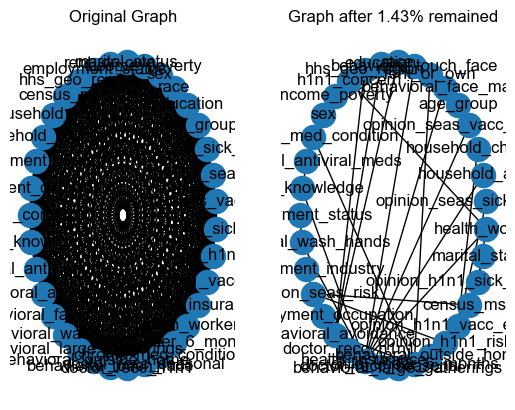

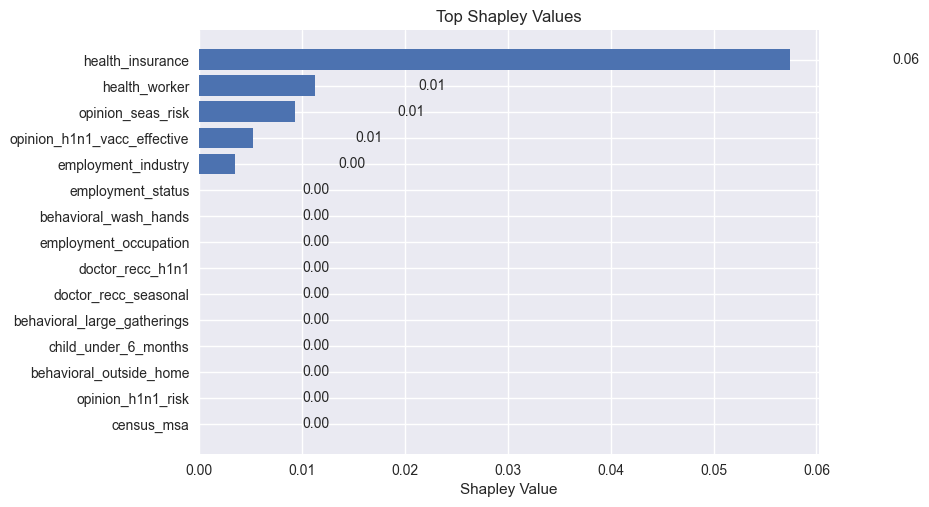

Processing ratio 0.06


100%|███████████████████████████████████████████| 35/35 [00:18<00:00,  1.85it/s]


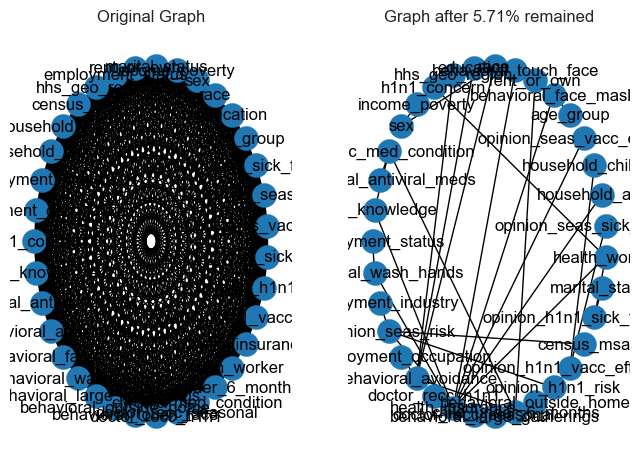

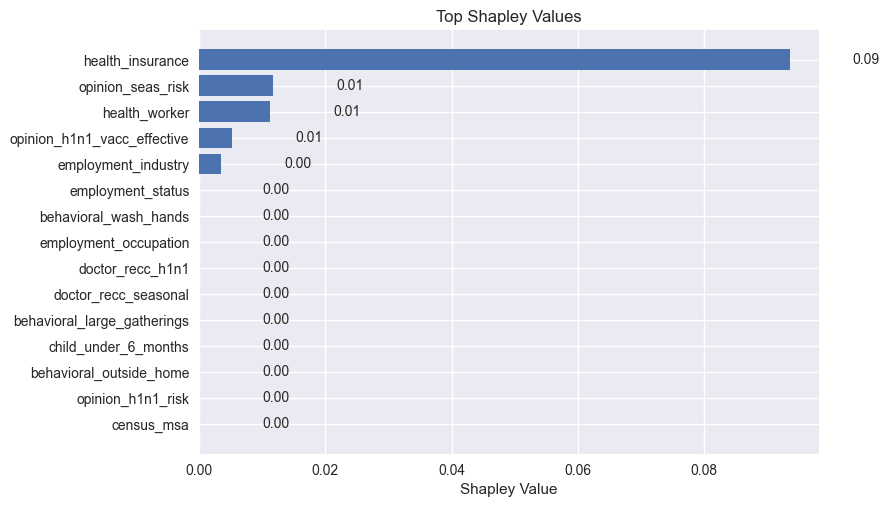

Processing ratio 0.10


100%|███████████████████████████████████████████| 35/35 [00:52<00:00,  1.50s/it]


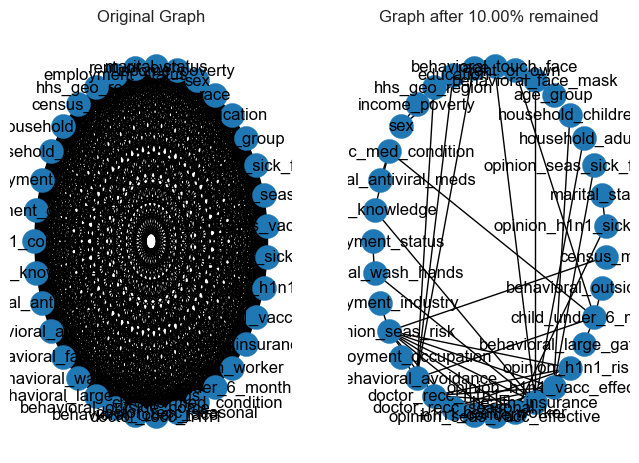

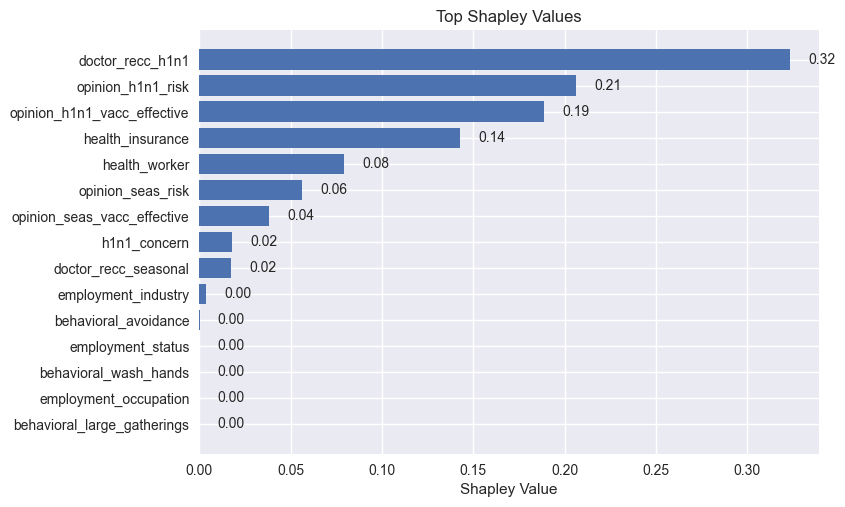

Processing ratio 0.14


100%|███████████████████████████████████████████| 35/35 [01:27<00:00,  2.49s/it]


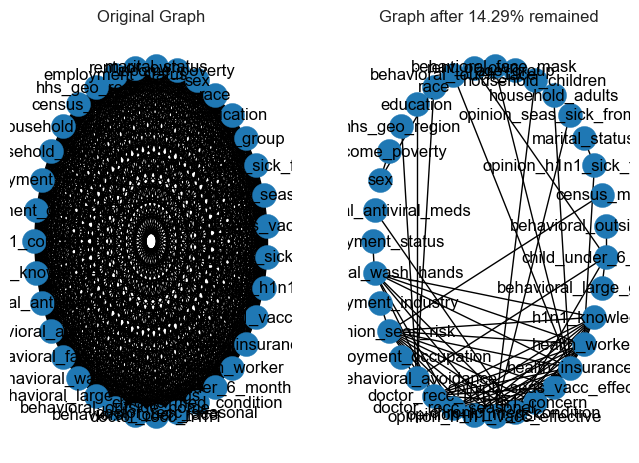

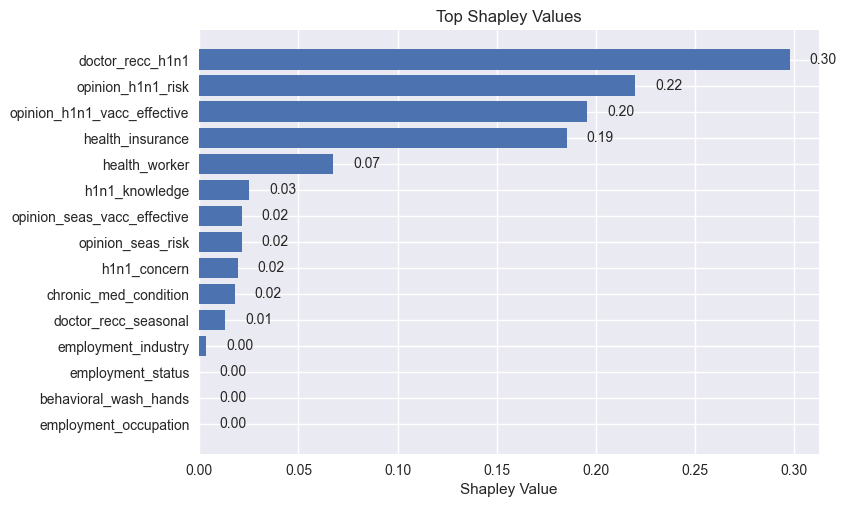

Processing ratio 0.19


100%|███████████████████████████████████████████| 35/35 [01:46<00:00,  3.04s/it]


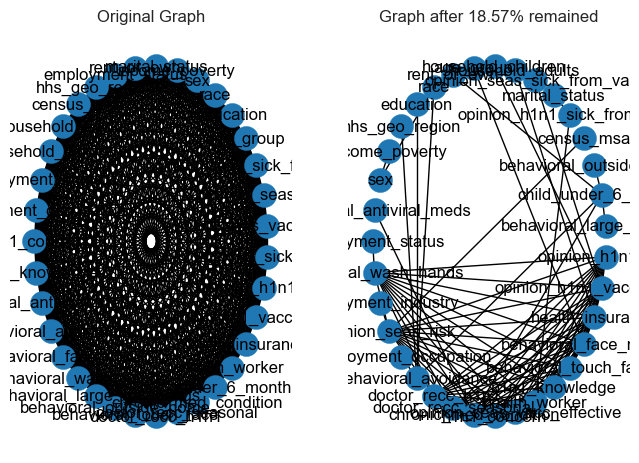

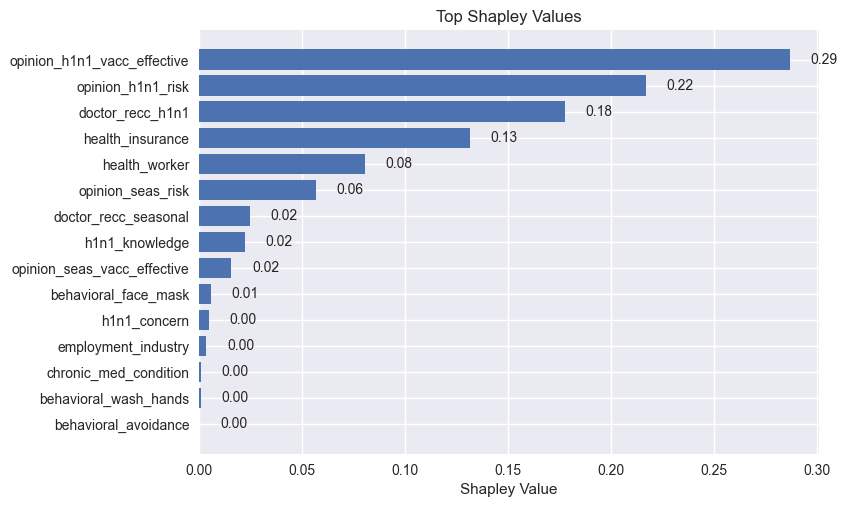

In [6]:
X, y =  h1n1_data_reader('process_data.csv')
rsts = {}
n_nodes = len(X.columns)
floor_ratio = (n_nodes - 1) / (n_nodes * (n_nodes -1)) / 2
epoch = 5
step_size = floor_ratio * 3
limit = floor_ratio + epoch * step_size

# rsts['pearsonr'] = run_on_different_ratio(X, y, limit, pearsonr, step=step_size)
rsts['kendalltau'] = run_on_different_ratio(X, y, limit, kendalltau, step=step_size)

In [7]:
for k, v in rsts.items():
    for kk, vv in v.items():
        print(f"{kk}: {vv['duration']:.2f} seconds")
        rank = [x[0] for x in vv['values']]
        print("feature ranking:", rank)

kendalltau-0.01: 20.44 seconds
feature ranking: ['health_insurance', 'health_worker', 'opinion_seas_risk', 'opinion_h1n1_vacc_effective', 'employment_industry', 'employment_status', 'behavioral_wash_hands', 'employment_occupation', 'doctor_recc_h1n1', 'doctor_recc_seasonal', 'behavioral_large_gatherings', 'child_under_6_months', 'behavioral_outside_home', 'opinion_h1n1_risk', 'census_msa', 'opinion_h1n1_sick_from_vacc', 'marital_status', 'opinion_seas_sick_from_vacc', 'household_adults', 'household_children', 'opinion_seas_vacc_effective', 'age_group', 'behavioral_face_mask', 'rent_or_own', 'behavioral_touch_face', 'race', 'education', 'hhs_geo_region', 'h1n1_concern', 'income_poverty', 'sex', 'chronic_med_condition', 'behavioral_antiviral_meds', 'h1n1_knowledge', 'behavioral_avoidance']
kendalltau-0.06: 20.52 seconds
feature ranking: ['health_insurance', 'opinion_seas_risk', 'health_worker', 'opinion_h1n1_vacc_effective', 'employment_industry', 'employment_status', 'behavioral_wash_ha

In [8]:
# X, y =  h1n1_data_reader('process_data.csv')
# sorted_values = run_with_ratio(X, y, 0.16, kendalltau)

In [9]:
# values_rank = get_rank(kendalltau, X, y)
# W = matrix_generator(X, kendalltau)
# mst = delete_by_rank(W, values_rank, 0.16)

# # 创建 G2
# G2 = nx.Graph()
# G2.add_weighted_edges_from(mst)


In [10]:
# plt.figure(figsize=(20, 20))  # 设置图形大小
# nx.draw_shell(G2, with_labels=True)  # 使用 shell 布局绘制 G2
# # plt.title("Graph after {:.2f}% remained".format(0.16 * 100))  # 添加标题
# plt.savefig('graph_improved.eps', format='eps', dpi=300)
# plt.show()  # 显

In [11]:
# sorted_values

In [12]:
# labels = [item[0] for item in sorted_values][::-1][:25]
# labels

In [13]:
# labels = [item[0] for item in sorted_values][:10][::-1]
# labels

In [14]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np
# labels = [item[0] for item in sorted_values][:10][::-1]
# values = [item[1] for item in sorted_values][:10][::-1]

# plt.figure(figsize=(8, 10))

# # 创建一个渐变颜色列表
# colors = plt.cm.Greens(np.linspace(0, 1, len(values)))

# # 使用 Matplotlib 的 barh() 函数绘制带有渐变颜色的水平条形图
# plt.barh(labels, values, color=colors)

# # 添加标签和标题
# plt.xlabel('Shapley Value')
# plt.ylabel('Features')
# # plt.title('Shapley Value for Each Feature in H1N1 Dataset', fontsize=14, pad=20)
# plt.tight_layout()

# # 保存图像
# # plt.savefig('h1n1_shapley_values_sorted.png', dpi=300)  # 保存为 PNG 文件
# # plt.savefig('h1n1_shapley_values_sorted.eps', format='eps', dpi=300)  # 保存为 EPS 文件

# # 显示图形
# plt.show()

In [15]:
# X, y = h1n1_data_reader('process_data.csv')

# rsts = {}

# rsts['kendalltau'] = run_on_different_ratio(X, y, 0.5, kendalltau, step=0.1)

In [16]:
# for k, v in rsts.items():
#     for kk, vv in v.items():
#         print(f"{kk}: {vv['duration']:.2f} seconds")
#         rank = [x[0] for x in vv['values']]
#         print("feature ranking:", rank)

In [17]:
rsts

{'kendalltau': {'kendalltau-0.01': {'values': [('health_insurance',
     0.05740102654093234),
    ('health_worker', 0.01129456458211572),
    ('opinion_seas_risk', 0.009293444734066918),
    ('opinion_h1n1_vacc_effective', 0.005207924098373536),
    ('employment_industry', 0.003518029903254178),
    ('employment_status', 0.0),
    ('behavioral_wash_hands', 0.0),
    ('employment_occupation', 0.0),
    ('doctor_recc_h1n1', 0.0),
    ('doctor_recc_seasonal', 0.0),
    ('behavioral_large_gatherings', 0.0),
    ('child_under_6_months', 0.0),
    ('behavioral_outside_home', 0.0),
    ('opinion_h1n1_risk', 0.0),
    ('census_msa', 0.0),
    ('opinion_h1n1_sick_from_vacc', 0.0),
    ('marital_status', 0.0),
    ('opinion_seas_sick_from_vacc', 0.0),
    ('household_adults', 0.0),
    ('household_children', 0.0),
    ('opinion_seas_vacc_effective', 0.0),
    ('age_group', 0.0),
    ('behavioral_face_mask', 0.0),
    ('rent_or_own', 0.0),
    ('behavioral_touch_face', 0.0),
    ('race', 0.0),
 

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
# from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import lightgbm as lgb

In [19]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
# Setting the custom styling and markers as per your request
plt.rcParams['font.family'] = 'cmu-serif'  # Adjusted due to 'cmu-serif' not found
plt.rcParams['text.usetex'] = True  # Disabled LaTeX rendering due to environment constraints
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=['c', 'm', 'g', 'y', 'b', 'r', 'orange', 'purple'])
plt.rcParams["legend.frameon"] = True
# markers = ['+','x','*','s','s','.','.','^','^','v','v','D','D','p']
markers = ['+','x','*','s','.','^','v','D','p']

def plot_feature_dropping_effects(X, y, method2dict, limit=11, plot_title='Comparison of accuracy after dropping features (LightGBM)', filename=None):  
    """  
    Function to plot the effect on prediction accuracy of dropping features based on various ratios of method2dict.  
    
    Parameters:  
    X (DataFrame): Feature matrix.  
    y (Series/DataFrame): Target variable.  
    method2dict (dict): Dictionary containing feature ranks and other details.  
    model: Machine learning model to be used for predictions.  
    plot_title (str): Title for the plot.  
    
    Returns:  
    Results (dict): Dictionary containing the features dropped and corresponding accuracies for each ratio value from method2dict.  
    """  
    x_train, x_test, y_train, y_test = train_test_split(X, y ,test_size= 0.2, random_state= 10)
    model = lgb.LGBMClassifier(learning_rate=0.02,
               min_child_samples=4, n_estimators=45, num_leaves=144,
               reg_alpha=0.1, reg_lambda=0.003,
               verbose=-1)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    initial_accuracy = accuracy_score(y_test, y_pred)
    results = {}

    plt.figure(figsize=(12, 8))
    method_marker_map = {method: markers[i % len(markers)] for i, method in enumerate(method2dict)}  

    for method, rst_dict in method2dict.items():
        for idx, (k, v) in enumerate(rst_dict.items()):  
            accuracies = [initial_accuracy]  
            features = [[]]  
            feature_rank = [x[0] for x in v['values']]  
            
            for i in range(1, limit):  
                features_to_drop = feature_rank[:i]  
                reduced_X = X.drop(columns=features_to_drop)  
                
                x_train, x_test, y_train, y_test = train_test_split(reduced_X, y, test_size=0.2, random_state=10)  
                
                model.fit(x_train, y_train)  
                y_pred = model.predict(x_test)  
                
                new_accuracy = accuracy_score(y_test, y_pred)  
                accuracies.append(new_accuracy)  
                features.append(features_to_drop)  
            
            results[k] = {'Features': features, 'Accuracies': accuracies}  
            
            plt.plot(range(0, limit), accuracies, marker=method_marker_map[method], label=k, alpha=1,markersize=5,  # 标记大小
            markeredgewidth=2)  
    
    plt.xlabel('Number of Features Dropped')  
    plt.ylabel('accuracy')  
    plt.title(plot_title)  
    plt.xticks(range(0, limit))  
    plt.legend()
    plt.grid()
    if filename != None:
        plt.savefig(filename, format='eps', dpi=300)
    plt.show() 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


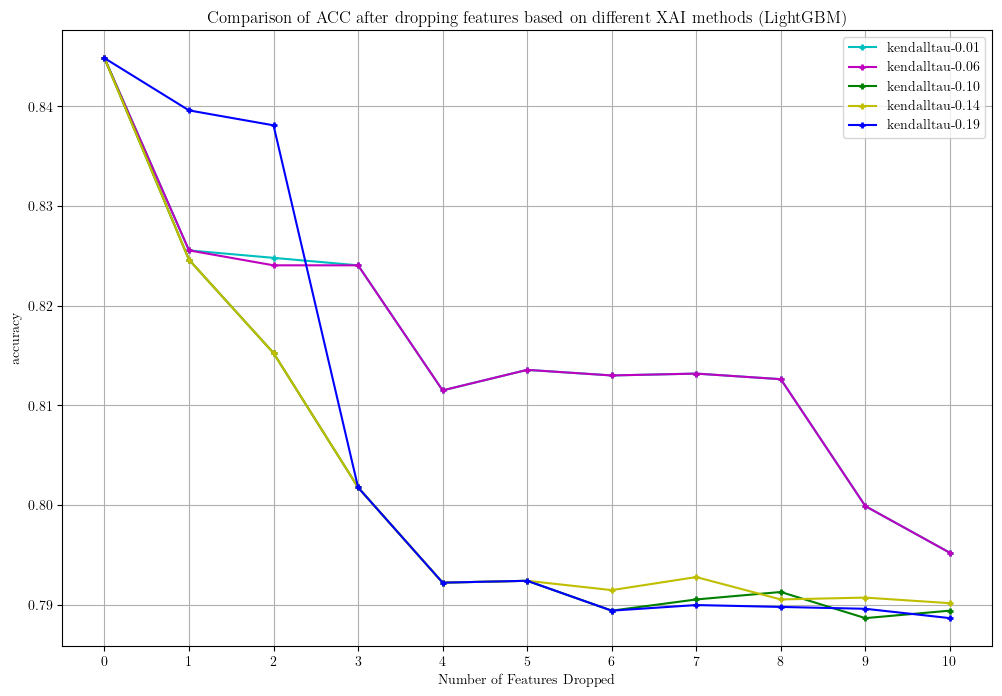

In [20]:
X, y = h1n1_data_reader('process_data.csv')

plot_feature_dropping_effects(X, y, rsts, limit=11, plot_title='Comparison of ACC after dropping features based on different XAI methods (LightGBM)', 
    filename='feature_dropping.eps')  

In [21]:
# manually add another results
rsts['ShapG'] = {'ShapG': {'values':[('doctor_recc_h1n1', 3.349334477082859),
 ('opinion_h1n1_risk', 1.6694648702040447),
 ('health_insurance', 0.6049110812869221),
 ('opinion_h1n1_vacc_effective', 0.5973179220833038),
 ('employment_occupation', 0.579053454136386),
 ('employment_industry', 0.400843506757103),
 ('health_worker', 0.3523409595771853),
 ('doctor_recc_seasonal', 0.31300902086124494),
 ('opinion_seas_risk', 0.24577119277065046),
 ('h1n1_knowledge', 0.12198475601643742),
 ('opinion_seas_vacc_effective', 0.11920816532100438),
 ('opinion_h1n1_sick_from_vacc', 0.09650688868217266),
 ('h1n1_concern', 0.0750150273484201),
 ('income_poverty', 0.06925762527660176),
 ('child_under_6_months', 0.05294342752908994),
 ('education', 0.04075265106583295)],
   'duration': 1567.1862950325012}}

In [22]:
# manually add another results
rsts['SHAP'] = {'SHAP': {'values':[('health_insurance', 3.349334477082859),
 ('doctor_recc_h1n1', 1.6694648702040447),
 ('opinion_h1n1_vacc_effective', 0.6049110812869221),
 ('opinion_h1n1_risk', 0.5973179220833038),
 ('opinion_seas_risk', 0.579053454136386),
 ('opinion_seas_vacc_effective', 0.400843506757103),
 ('doctor_recc_seasonal', 0.3523409595771853),
 ('hhs_geo_region', 0.31300902086124494),
 ('employment_occupation', 0.24577119277065046),
 ('opinion_seas_sick_from_vacc', 0.12198475601643742)],
   'duration': 0.1}}

In [23]:
# manually add another results
rsts['SamplingSHAP'] = {'SamplingSHAP': {'values':[('doctor_recc_h1n1', 3.349334477082859),
 ('health_insurance', 1.6694648702040447),
 ('opinion_h1n1_risk', 0.6049110812869221),
 ('opinion_h1n1_vacc_effective', 0.5973179220833038),
 ('opinion_seas_risk', 0.579053454136386),
 ('age_group', 0.400843506757103),
 ('hhs_geo_region', 0.3523409595771853),
 ('opinion_h1n1_sick_from_vacc', 0.31300902086124494),
 ('employment_occupation', 0.24577119277065046),
 ('employment_industry', 0.12198475601643742)],
   'duration': 22440}}

In [24]:
# manually add another results
rsts['LIME'] = {'LIME': {'values':[('doctor_recc_h1n1', 3.349334477082859),
 ('health_insurance', 1.6694648702040447),
 ('opinion_h1n1_vacc_effective', 0.6049110812869221),
 ('health_worker', 0.5973179220833038),
 ('marital_status', 0.579053454136386),
 ('opinion_seas_risk', 0.400843506757103),
 ('opinion_h1n1_risk', 0.3523409595771853),
 ('employment_occupation', 0.31300902086124494),
 ('opinion_h1n1_sick_from_vacc', 0.24577119277065046),
 ('behavioral_avoidance', 0.12198475601643742)],
   'duration': 0.180}}

In [25]:
# manually add another results
rsts['FI'] = {'FI': {'values':[('hhs_geo_region', 3.349334477082859),
 ('employment_occupation', 1.6694648702040447),
 ('employment_industry', 0.6049110812869221),
 ('age_group', 0.5973179220833038),
 ('opinion_h1n1_vacc_effective', 0.579053454136386),
 ('opinion_h1n1_risk', 0.400843506757103),
 ('census_msa', 0.3523409595771853),
 ('education', 0.31300902086124494),
 ('opinion_seas_risk', 0.24577119277065046),
 ('income_poverty', 0.12198475601643742)],
   'duration': 0.0862950325012}}

In [26]:
# manually add another results
rsts['PFI'] = {'PFI': {'values':[('doctor_recc_h1n1', 3.349334477082859),
 ('health_insurance', 1.6694648702040447),
 ('opinion_h1n1_risk', 0.6049110812869221),
 ('opinion_h1n1_vacc_effective', 0.5973179220833038),
 ('health_worker', 0.579053454136386),
 ('race', 0.400843506757103),
 ('age_group', 0.3523409595771853),
 ('opinion_seas_risk', 0.31300902086124494),
 ('opinion_seas_vacc_effective', 0.24577119277065046),
 ('employment_industry', 0.12198475601643742)],
   'duration': 1.1862950325012}}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


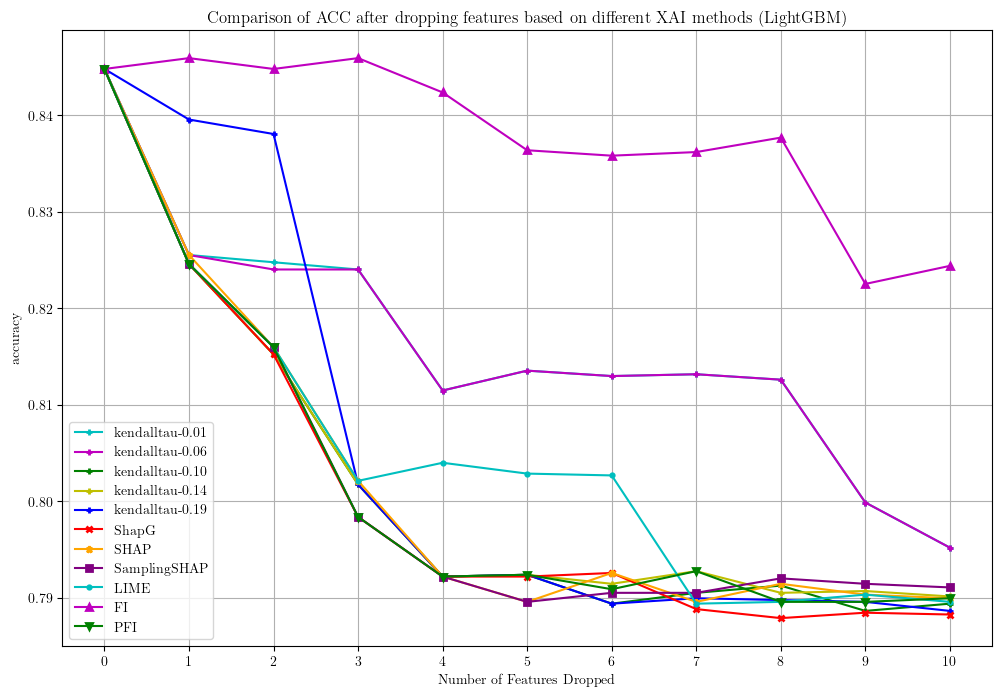

In [27]:
plot_feature_dropping_effects(X, y, rsts, limit=11, plot_title='Comparison of ACC after dropping features based on different XAI methods (LightGBM)', 
    filename='feature_dropping_withXAI')  

In [28]:
def compute_weighted_slope(X, y, method2dict, limit=10):
    """
    Function to calculate weighted slopes of decrease in prediction accuracy after dropping features.

    Parameters:
    X (DataFrame): Feature matrix.
    y (Series/DataFrame): Target variable.
    method2dict (dict): Dictionary containing feature ranks and other details.

    Returns:
    Results (dict): Dictionary containing the weighted sum of slopes for each ratio value from method2dict.
    """
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
    model = lgb.LGBMClassifier(learning_rate=0.02,
               min_child_samples=4, n_estimators=45, num_leaves=144,
               reg_alpha=0.1, reg_lambda=0.003,
               verbose=-1)    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    initial_accuracy = accuracy_score(y_test, y_pred)
    results = {}

    for method, rst_dict in method2dict.items():
        print(f"\nMethod: {method}")  # 输出当前方法
        for idx, (k, v) in enumerate(rst_dict.items()):
            accuracies = [initial_accuracy]
            slopes = []
            feature_rank = [x[0] for x in v['values']]

            for i in range(1, limit):
                features_to_drop = feature_rank[:i]
                reduced_X = X.drop(columns=features_to_drop)

                x_train, x_test, y_train, y_test = train_test_split(reduced_X, y, test_size=0.2, random_state=10)

                model.fit(x_train, y_train)
                y_pred = model.predict(x_test)

                new_accuracy = accuracy_score(y_test, y_pred)
                accuracies.append(new_accuracy)

                # 计算斜率：新精度与前一精度之间的差异
                slope = (accuracies[-2] - new_accuracy)
                slopes.append(slope)

            # 计算加权斜率
            weights = np.linspace(1, 0.1, num=limit-1)  # 权重从1递减到0.1
            weighted_slopes = np.array(slopes) * weights
            total_weighted_slope = np.sum(weighted_slopes)
            rst_dict[k]['Slope'] = total_weighted_slope
            results[k] = total_weighted_slope

            # 打印加权斜率结果
            print(f"Rank: {k}, Weighted Slope: {total_weighted_slope}")

    return results, method2dict

In [29]:
X, y = h1n1_data_reader()
_, new_rsts = compute_weighted_slope(X, y, rsts, limit=11)


Method: kendalltau
Rank: kendalltau-0.01, Weighted Slope: 0.03148633470610252
Rank: kendalltau-0.06, Weighted Slope: 0.031561213028828104
Rank: kendalltau-0.10, Weighted Slope: 0.04726694122051661
Rank: kendalltau-0.14, Weighted Slope: 0.046630475477349255
Rank: kendalltau-0.19, Weighted Slope: 0.043672781729689206

Method: ShapG
Rank: ShapG, Weighted Slope: 0.04794084612504673

Method: SHAP
Rank: SHAP, Weighted Slope: 0.04687383002620736

Method: SamplingSHAP
Rank: SamplingSHAP, Weighted Slope: 0.04717334331710966

Method: LIME
Rank: LIME, Weighted Slope: 0.043691501310370605

Method: FI
Rank: FI, Weighted Slope: 0.0076001497566454005

Method: PFI
Rank: PFI, Weighted Slope: 0.04717334331710965


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


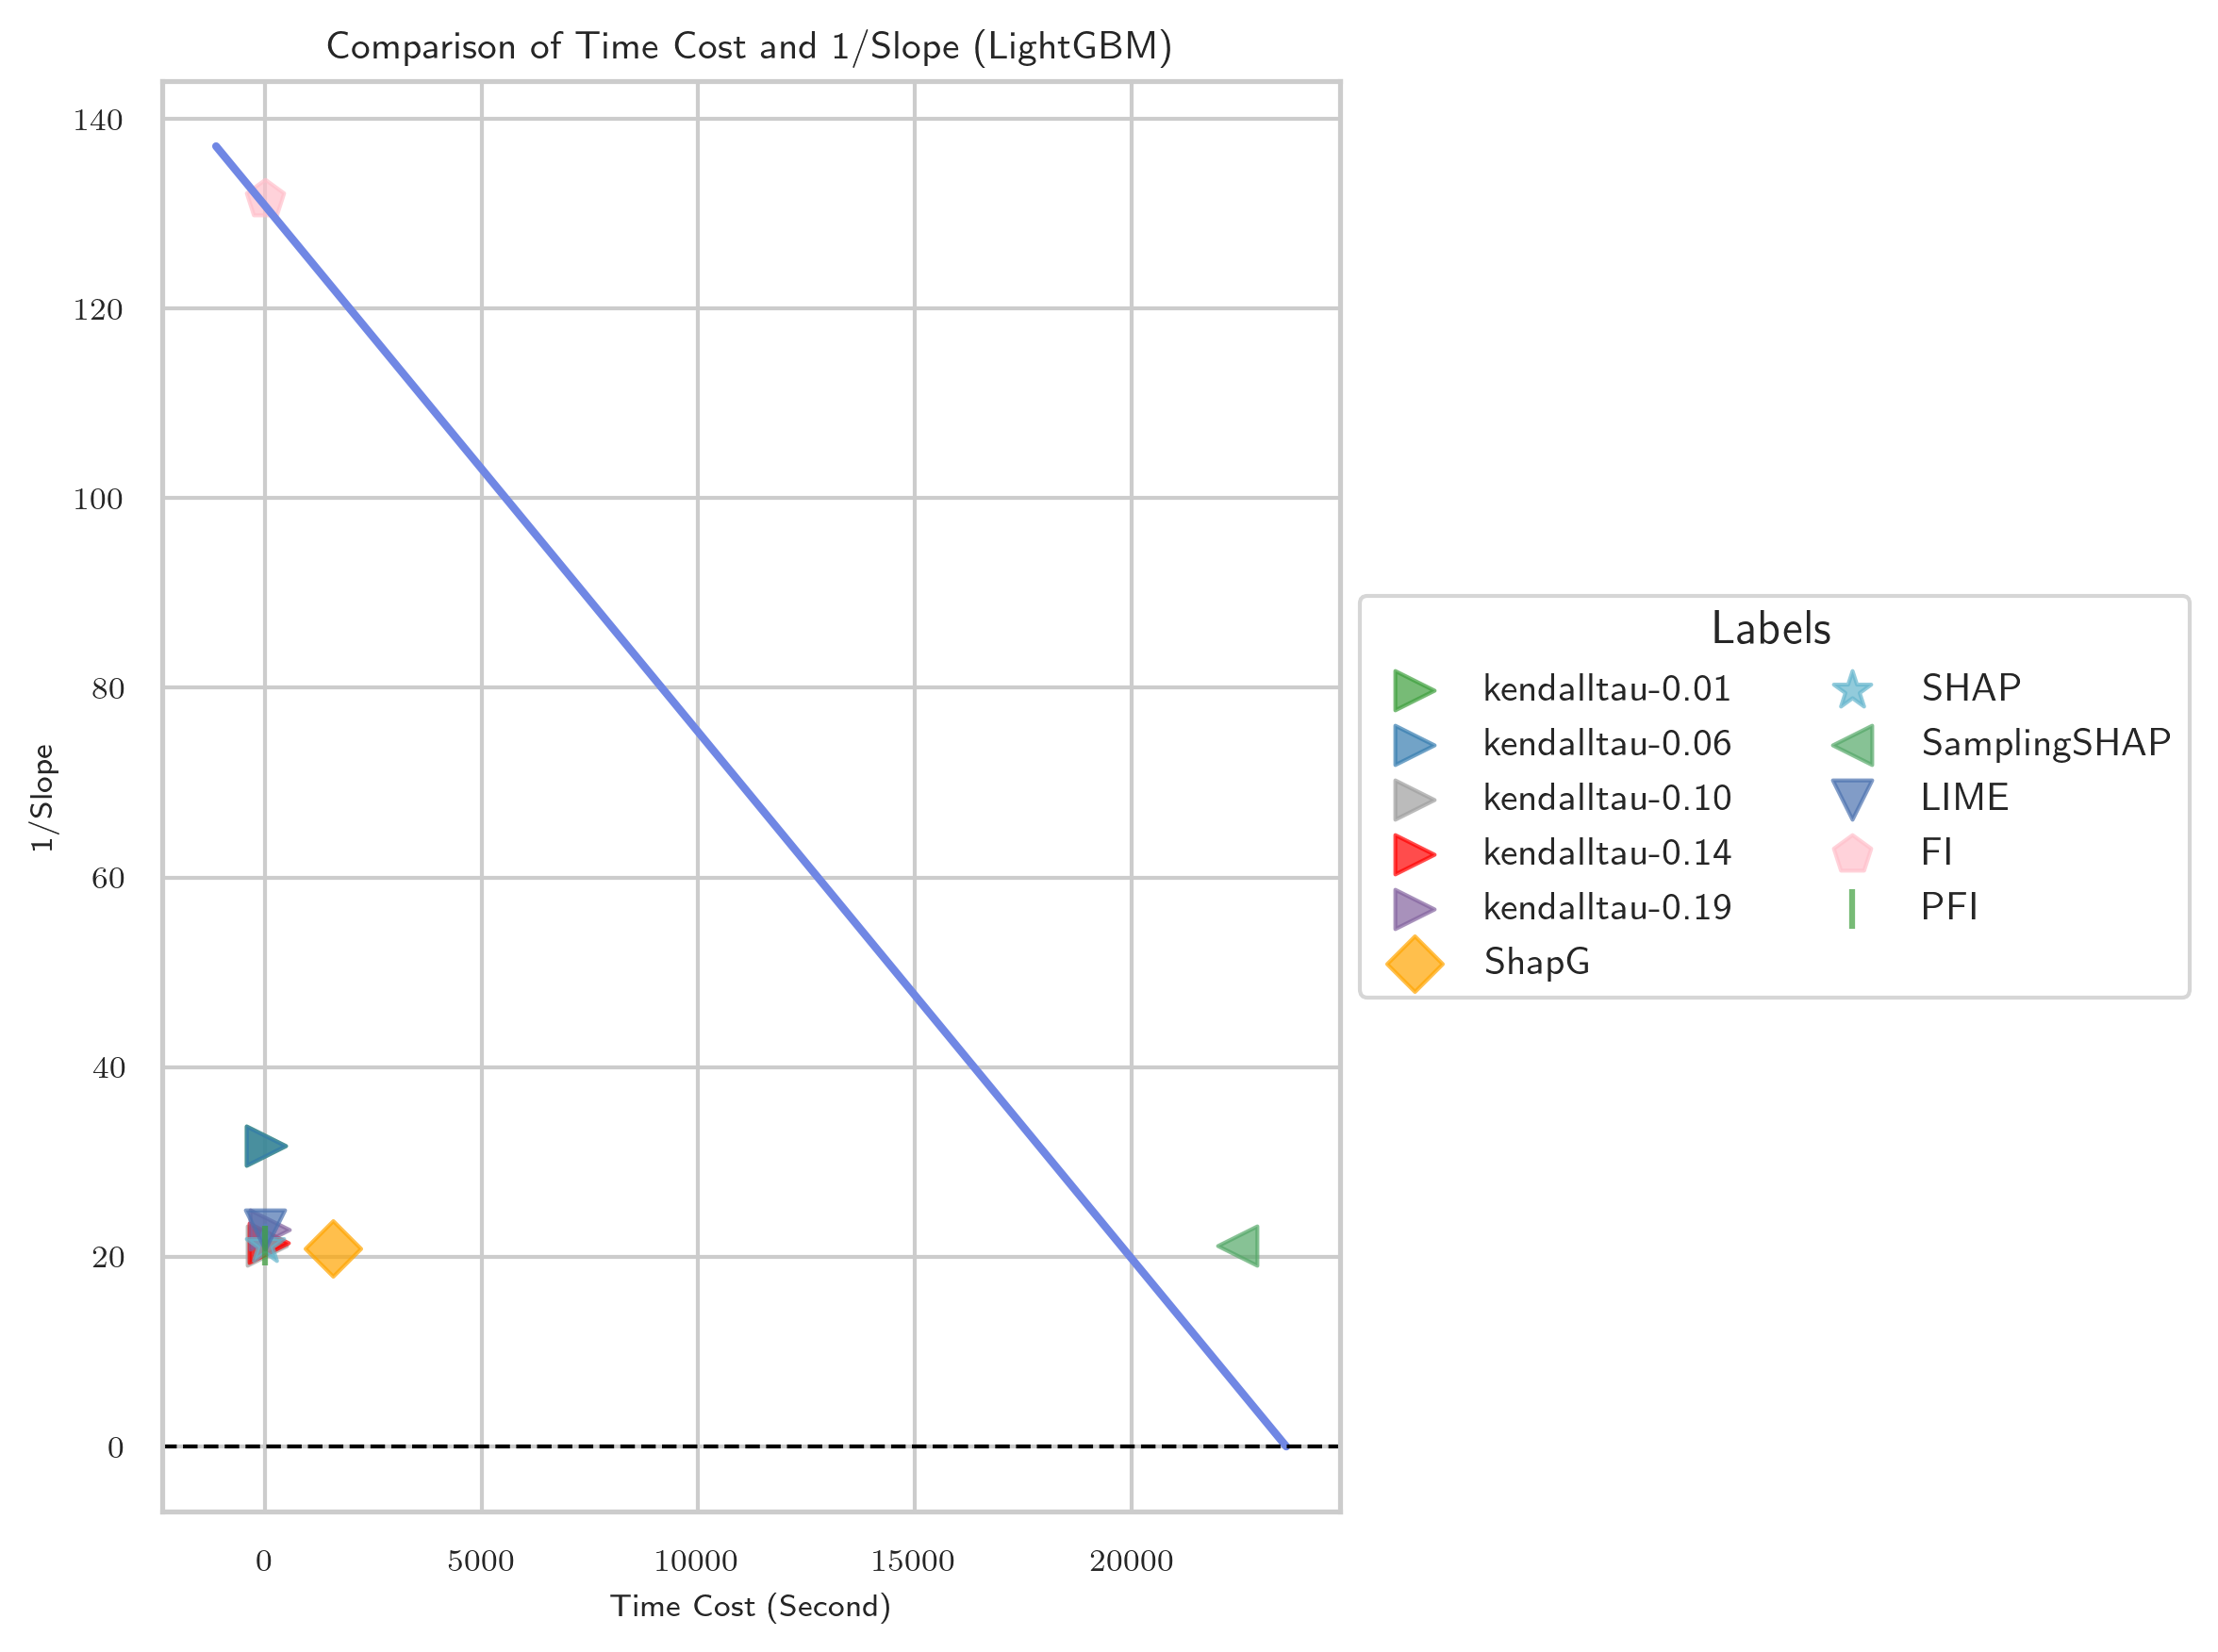

In [30]:
triple = []
for method, rst_dict in new_rsts.items():
    for k, v in rst_dict.items():
        triple.append((v['Slope'], v['duration'], f"{k}", method))  # Include method in the tuple

# plt.rcParams["axes.prop_cycle"] = plt.cycler(color=[
#     '#1f77b4',  # A pleasant blue
#     '#ff7f0e',  # A warm orange
#     '#2ca02c',  # A soft green
#     '#d62728',  # A vibrant red
#     '#9467bd',  # A muted purple
#     '#8c564b',  # A faded brown
#     '#e377c2',  # A light pink
#     '#7f7f7f',  # A neutral grey
#     '#bcbd22',  # A yellow-green
#     '#17becf'   # A cyan
# ])

method_marker_map = {
    'pearsonr': 'o',  # Circle
    'kendalltau': '>',
    'spearmanr': 's',  # Square
    'cosine': 'H',  # Star
    'ShapG': 'D',
    'SHAP':'*',
    'SamplingSHAP':'<',
#     'KernelSHAP':'<',
    'LIME': 'v',
    'FI': 'p',  # Pentagon
    'PFI': '|'
    # Triangle right
    # Add more methods and markers as needed
}
predefined_colors = [
    '#3D9F3C',  # A pleasant blue
    '#367DB0',  # A warm orange
    '#9f9f9f',  # A soft green
    'red',  # A vibrant red
    '#83639F',  # A muted purple
    'orange',
    'c',
    'g',
    'b',
    'pink'   # A faded brown
#     'gray',  # A light pink
#     'black'  # A neutral grey
]

def plot_by_triple(triple):
    """
    triple: (slope, time cost, label, method)
    x: time cost
    y: slope
    write label on each point
    """
    x = [x[1] for x in triple]
    y = [1/x[0] for x in triple]
    labels = [x[2] for x in triple]
    methods = [x[3] for x in triple]

    # Use Seaborn to set style
    sns.set(style="whitegrid")

    plt.figure(figsize=(8, 6), dpi=300)  # Adjust dpi as needed

    # Create a dictionary to hold legend handles
    legend_handles = []

    for i, (xi, yi, label, method) in enumerate(zip(x, y, labels, methods)):
        marker = method_marker_map.get(method, 'o')  # Default to 'o' if method not found
        color = predefined_colors[i % len(predefined_colors)]  # Use colors cyclically
        sc = plt.scatter(xi, yi, s=100, c=[color], alpha=0.7, marker=marker)
#         plt.annotate(label, (xi, yi), textcoords="offset points", xytext=(5, -5), ha='left', fontsize=10)

        # Collect handles for creating a legend entry per label
        legend_handles.append((sc, label))

    plt.xlabel('Time Cost (Second)', fontsize=8)
    plt.ylabel('1/Slope', fontsize=8)
    plt.title('Comparison of Time Cost and 1/Slope (LightGBM)', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    
    # Add a diagonal line from bottom-left to top-right
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    plt.plot([x_min, x_max], [y_max, 0], color='#7087E4', linestyle='-', linewidth=2)
    
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)

    # Add a legend to the right side of the plot
    plt.legend(*zip(*legend_handles), title="Labels", loc='center left',  ncol=2, bbox_to_anchor=(1, 0.5), fontsize=10)  # Adjust fontsize and position
#     plt.legend(*zip(*legend_handles), bbox_to_anchor=(0.5, -0.05),
#            ncol=2, shadow=True, title="Legend Title")

    # Optimize display
    plt.tight_layout()
    plt.savefig('slope.eps', format='eps', dpi=300)

    plt.show()

# Call the function with your triple data
plot_by_triple(triple)

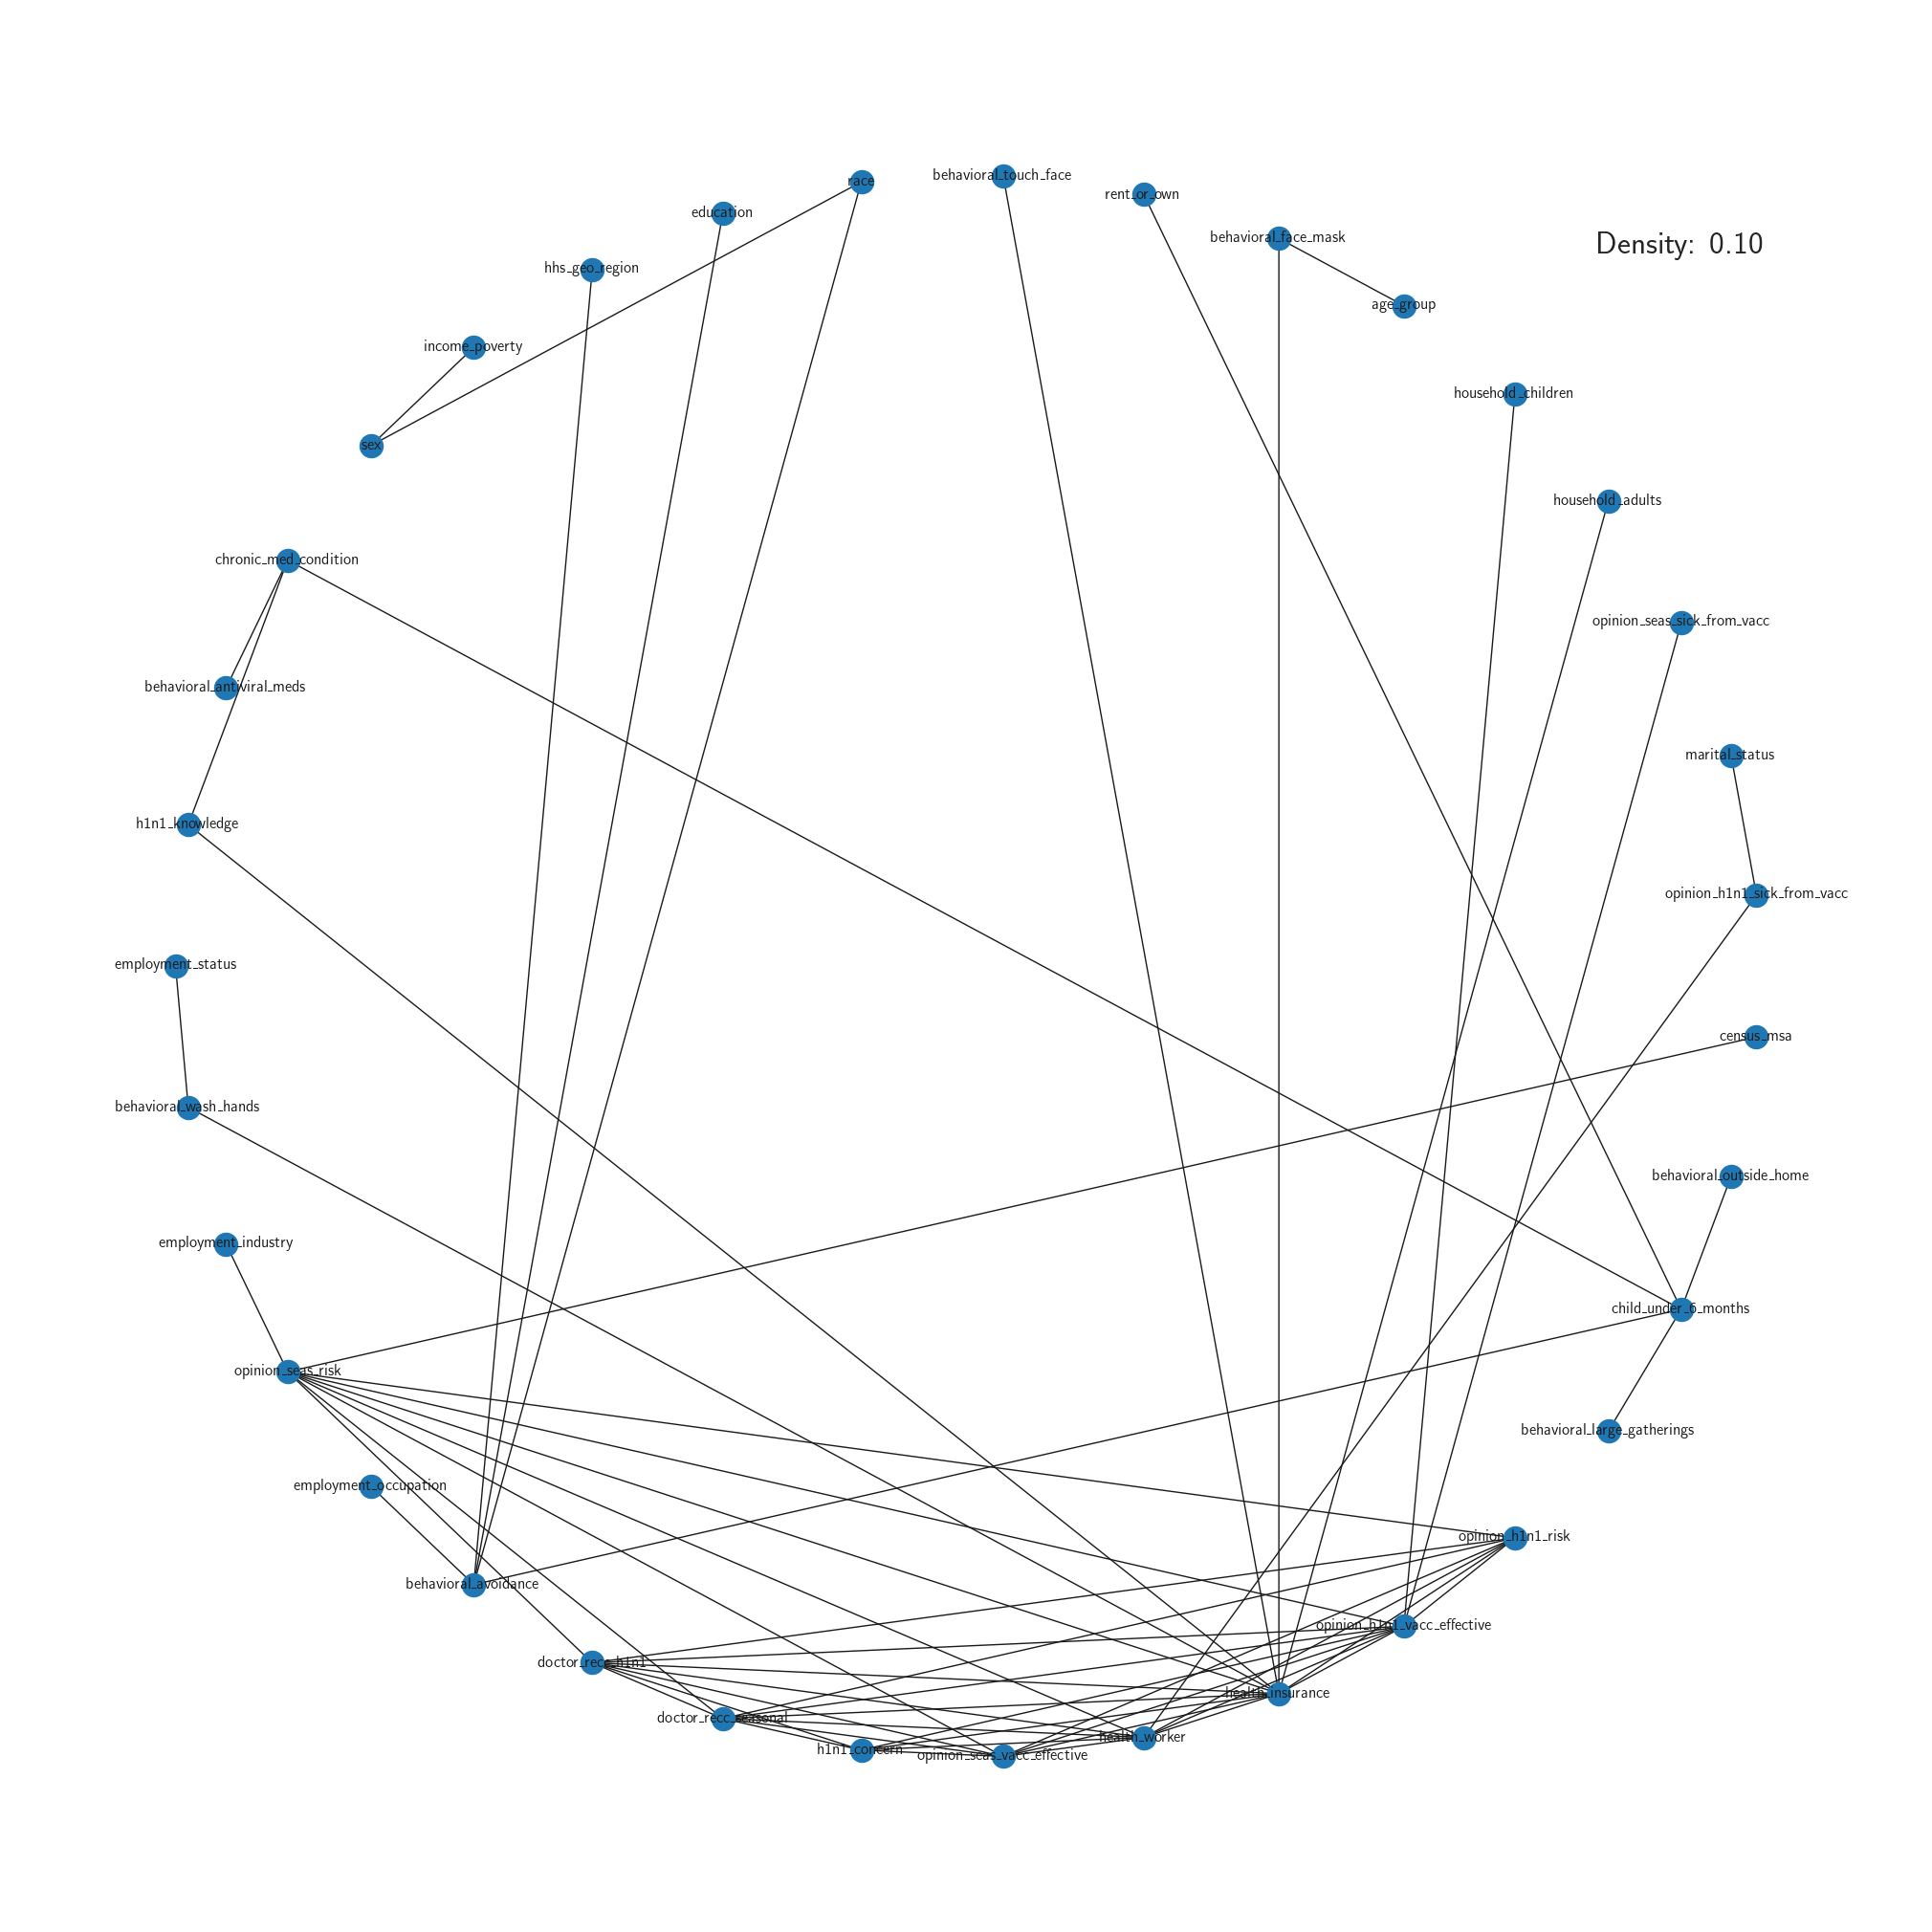

In [32]:
values_rank = get_rank(kendalltau, X, y)
W = matrix_generator(X, kendalltau)
mst = delete_by_rank(W, values_rank, 0.10)
G = nx.Graph(W)
# 创建 G2
G2 = nx.Graph()
density = nx.density(G2)
G2.add_weighted_edges_from(mst)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.figure(figsize=(20, 20))  # 设置图形大小
nx.draw_shell(G2, with_labels=True)  # 使用 shell 布局绘制 G2
plt.text(0.9, 0.9, f"Density: 0.10", fontsize=24, fontfamily='Arial', ha='center')
# plt.title("Graph after {:.2f}% remained".format(0.16 * 100))  # 添加标题
plt.savefig('graph_improved_lgb.eps', format='eps', dpi=300)
plt.show() 